In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/Users/paolocarminevalletta/Documents/SE4AI/Fairness_datasmell_SE4AI/ambiente/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [5]:
def compute_performance_metrics(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} Recall: {recall}")
    print(f"{model_name} F1 Score: {f1_score_value}")

def compute_classification_metric(dataset, predictions, label_name_v, favorable_label_v, unfavorable_label_v, privileged_attribute, unprivileged_attributes):
    features = [privileged_attribute] + unprivileged_attributes

    aif_race_dataset = BinaryLabelDataset(
            df=dataset,
            favorable_label=favorable_label_v,
            unfavorable_label=unfavorable_label_v,
            label_names=[label_name_v],
            protected_attribute_names=features,
            privileged_protected_attributes=[privileged_attribute],
        )

    aif_race_pred = BinaryLabelDataset(
            df=predictions,
            favorable_label=favorable_label_v,
            unfavorable_label=unfavorable_label_v,
            label_names=[label_name_v],
            protected_attribute_names=features,
            privileged_protected_attributes=[privileged_attribute],
        )

    race_privileged_group = [{privileged_attribute: 1}]
    race_unprivileged_groups = [{attr: 1} for attr in unprivileged_attributes]

    fairness_metrics = ClassificationMetric(dataset=aif_race_dataset,
                            classified_dataset=aif_race_pred,
                            unprivileged_groups=race_unprivileged_groups,
                            privileged_groups=race_privileged_group)
    
    return fairness_metrics

def compute_fairness_metrics(fairness_metrics: ClassificationMetric):
    # Values less than 0 indicate that privileged group has higher
    # proportion of predicted positive outcomes than unprivileged group.
    # Value higher than 0 indicates that unprivileged group has higher proportion
    # of predicted positive outcomes than privileged group.
    SPD = round(fairness_metrics.statistical_parity_difference(),3)

    # Measures the deviation from the equality of opportunity, which means that the same
    # proportion of each population receives the favorable outcome. This measure must be equal to 0 to be fair.
    EOD = round(fairness_metrics.equal_opportunity_difference(),3)

    # Average of difference in False Positive Rate and True Positive Rate for unprivileged and privileged groups
    # A value of 0 indicates equality of odds, which means that samples in both the privileged and unprivileged
    # groups have the same probability of being classified positively.
    AOD = round(fairness_metrics.average_odds_difference(),3)

    print(f"Statistical Parity Difference (SPD): {SPD}")
    print(f"Average Odds Difference (AOD): {AOD}")
    print(f"Equal Opportunity Difference (EOD): {EOD}")

In [2]:
df_tidy = pd.read_csv("../rawAdult/rawAdult.csv")
df_tidy.head()
print("colonne ed entries",df_tidy.shape)

colonne ed entries (48843, 15)


In [3]:
# Drop rows with missing values because all the column in that rows are missing
df_tidy = df_tidy.dropna()
print("colonne ed entries after drop",df_tidy.shape)

colonne ed entries after drop (48842, 15)


In [6]:
#for age column --> Integer as String data smells
# Converti i valori non numerici in NaN
df_tidy['age'] = pd.to_numeric(df_tidy['age'], errors='coerce')

# Ora dovresti essere in grado di convertire in int
df_tidy['age'] = df_tidy['age'].astype(int)
print(df_tidy['age'].dtype)

int64


In [7]:
#for capital-gain column --> Integer as floating data smells
df_tidy['capital-gain'] = df_tidy['capital-gain'].astype(int)
print(df_tidy['capital-gain'].dtype)

int64


In [8]:
#for capital-loss column --> Integer as floating data smells
df_tidy['capital-loss'] = df_tidy['capital-loss'].astype(int)
print(df_tidy['capital-loss'].dtype)

int64


In [9]:
#for education-num column --> Integer as floating data smells
df_tidy['education-num'] = df_tidy['education-num'].astype(int)
print(df_tidy['education-num'].dtype)

int64


In [10]:
#for fnlwgt column --> Integer as floating data smells
df_tidy['fnlwgt'] = df_tidy['fnlwgt'].astype(int)
print(df_tidy['fnlwgt'].dtype)

int64


In [4]:
#for hours-per-week column --> Integer as floating data smells
df_tidy['hours-per-week'] = df_tidy['hours-per-week'].astype(int)
print(df_tidy['hours-per-week'].dtype)

int64


In [11]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 48842
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


In [12]:
int_columns = df_tidy.select_dtypes(include='int64').columns
print(int_columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [13]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 48842
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


In [14]:
df_tidy[int_columns].head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


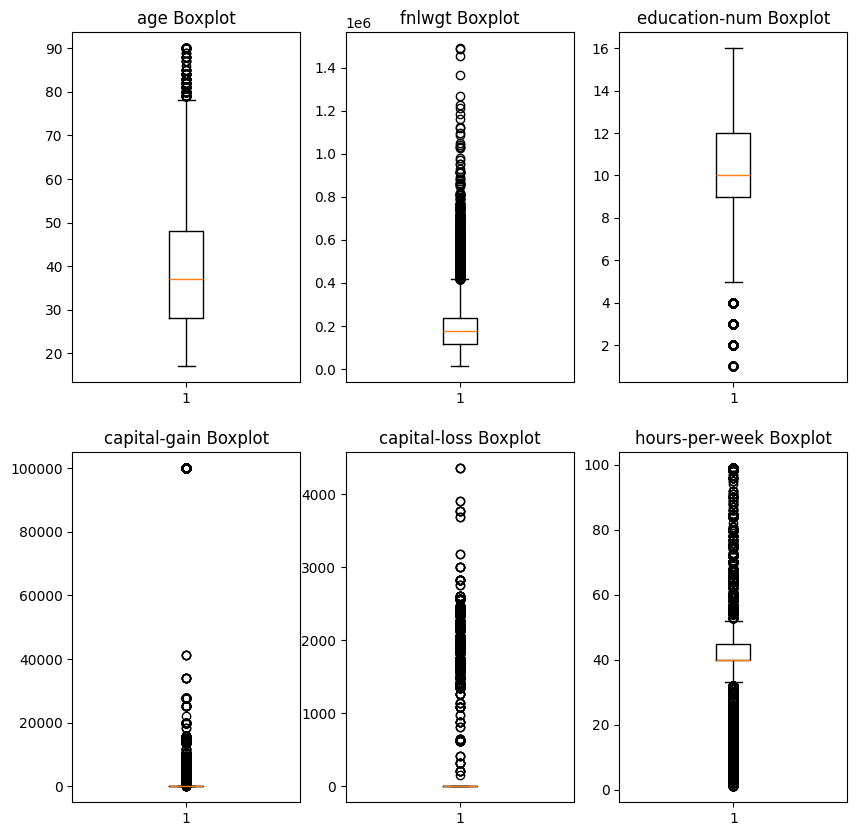

In [15]:
#Verified wether there are still outlier values by employing boxplot
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

for index,attribute in enumerate(int_columns):
    row = index // 3
    col = index % 3
    axs[row,col].boxplot(df_tidy[attribute])
    axs[row,col].set_title(attribute + ' Boxplot')
plt.show()

In [16]:
def calculate_interquartil_interval(column_name):
    Q1 = df_tidy[column_name].quantile(0.25)
    Q3 = df_tidy[column_name].quantile(0.75)

    # Calcolo dell'intervallo interquartile (IQR)
    IQR = Q3 - Q1

    # Determinazione dei limiti inferiore e superiore per gli outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

def outliers_count_all(column_names):
    for column in column_names:
        lower_bound, upper_bound = calculate_interquartil_interval(column)
        outliers = df_tidy[(df_tidy[column] < lower_bound) | (df_tidy[column] > upper_bound)]
        print(f"numbers of outliers for {column} column: {outliers.shape[0]}")

def outliers_count(column_name):
    lower_bound, upper_bound = calculate_interquartil_interval(column_name)
    outliers = df_tidy[(df_tidy[column_name] < lower_bound) | (df_tidy[column_name] > upper_bound)]
    print(f"numbers of outliers for {column_name} column: {outliers.shape[0]}")

def delete_outlier(column_name):
    lower_bound, upper_bound = calculate_interquartil_interval(column_name)
    df_filtered = df_tidy[(df_tidy[column_name] >= lower_bound) & (df_tidy[column_name] <= upper_bound)]
    return df_filtered

In [17]:
outliers_count_all(int_columns)

numbers of outliers for age column: 216
numbers of outliers for fnlwgt column: 1453
numbers of outliers for education-num column: 1794
numbers of outliers for capital-gain column: 4035
numbers of outliers for capital-loss column: 2282
numbers of outliers for hours-per-week column: 13496


In [18]:
df_tidy = delete_outlier('age')
df_tidy = delete_outlier('fnlwgt')
df_tidy = delete_outlier('education-num')
df_tidy = delete_outlier('capital-gain')
df_tidy = delete_outlier('capital-loss')

In [19]:
#for age column, the tool shown that there aren't outliers
outliers_count_all(int_columns)

numbers of outliers for age column: 17
numbers of outliers for fnlwgt column: 405
numbers of outliers for education-num column: 0
numbers of outliers for capital-gain column: 0
numbers of outliers for capital-loss column: 0
numbers of outliers for hours-per-week column: 10978


In [20]:
df_tidy['fnlwgt'] = np.sqrt(df_tidy['fnlwgt']).astype(int)

In [21]:
int_columns = df_tidy.select_dtypes(include=['float64', 'int64']).columns
outliers_count_all(int_columns)

numbers of outliers for age column: 17
numbers of outliers for fnlwgt column: 7
numbers of outliers for education-num column: 0
numbers of outliers for capital-gain column: 0
numbers of outliers for capital-loss column: 0
numbers of outliers for hours-per-week column: 10978


In [22]:
int_columns = df_tidy.select_dtypes(include=['float64', 'int64']).columns
outliers_count_all(int_columns)

numbers of outliers for age column: 17
numbers of outliers for fnlwgt column: 7
numbers of outliers for education-num column: 0
numbers of outliers for capital-gain column: 0
numbers of outliers for capital-loss column: 0
numbers of outliers for hours-per-week column: 10978


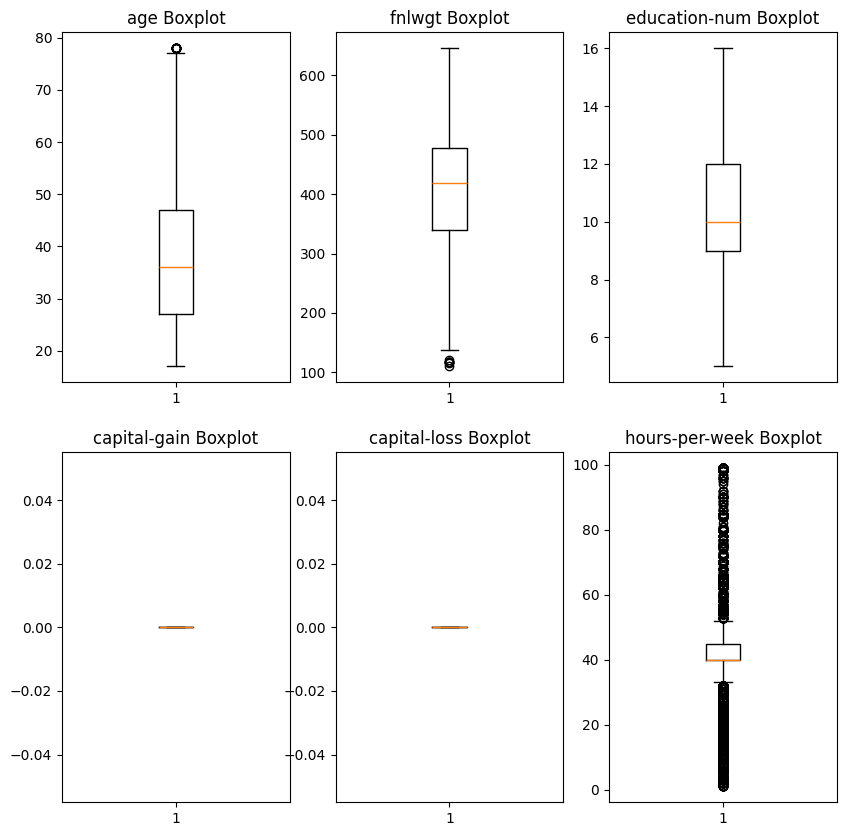

In [23]:
#Verified wether there are still outlier values by employing boxplot
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

for index,attribute in enumerate(int_columns):
    row = index // 3
    col = index % 3
    axs[row,col].boxplot(df_tidy[attribute])
    axs[row,col].set_title(attribute + ' Boxplot')
plt.show()

In [24]:
df_tidy['hours-per-week'].value_counts()

hours-per-week
40    18637
50     3247
45     2147
60     1661
35     1594
      ...  
91        2
82        1
94        1
87        1
69        1
Name: count, Length: 95, dtype: int64

In [25]:
df_tidy['capital-gain'].value_counts()

capital-gain
0    39538
Name: count, dtype: int64

In [26]:
df_tidy['capital-loss'].value_counts()

capital-loss
0    39538
Name: count, dtype: int64

In [27]:
columns_to_drop = ['capital-gain', 'capital-loss']
df_tidy = df_tidy.drop(columns=columns_to_drop)
df_tidy.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
1,50,Self-emp-not-inc,288,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,464,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,484,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,581,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K
5,37,Private,533,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K


Calcolo metriche

In [30]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39538 entries, 1 to 48842
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             39538 non-null  int64 
 1   workclass       39538 non-null  object
 2   fnlwgt          39538 non-null  int64 
 3   education       39538 non-null  object
 4   education-num   39538 non-null  int64 
 5   marital-status  39538 non-null  object
 6   occupation      39538 non-null  object
 7   relationship    39538 non-null  object
 8   race            39538 non-null  object
 9   sex             39538 non-null  object
 10  hours-per-week  39538 non-null  int64 
 11  native-country  39538 non-null  object
 12  income          39538 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.2+ MB


In [28]:
category_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship','race','sex','native-country']
df_tidy = pd.get_dummies(df_tidy, columns=category_columns, drop_first=True)

In [29]:
pd.set_option('display.max_columns', None)
df_tidy['sex_Female'] = ~df_tidy['sex_Male'] # We add a new column that is the opposite
df_tidy['income'] = df_tidy['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
df_tidy.head()

,age,fnlwgt,education-num,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Prof-school,education_Some-college,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Female
1,50,288,13,13,0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,38,464,9,40,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,53,484,7,40,0,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,28,581,13,40,0,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,Fal

In [30]:
df_tidy.to_csv('tidyAdult-trained.csv', index=False)

In [34]:
X = df_tidy.drop(columns="income")
y = df_tidy["income"]

# Define four sets and apply the function
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 0.2 indicates a test set size of 20%
                                                    random_state=42)

In [35]:
dt_clf = DecisionTreeClassifier(random_state=42)

# The fit function will do the trick
dt_clf.fit(X_train, y_train)

# After the training phase, the model will be tested by predicting the values on the test set
dt_predictions = dt_clf.predict(X_test)

compute_performance_metrics(y_test,dt_predictions,"Decision Tree")

Decision Tree Accuracy: 0.798811330298432
Decision Tree Recall: 0.48350253807106597
Decision Tree F1 Score: 0.4892455858747994


In [36]:
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Addestro il classificatore sui dati di training
svm_classifier.fit(X_train, y_train)

# predizioni sui dati di test
svm_pred = svm_classifier.predict(X_test)

compute_performance_metrics(y_test,svm_pred,"SVM")

SVM Accuracy: 0.8373798684876075
SVM Recall: 0.39847715736040606
SVM F1 Score: 0.4940991345397325


In [37]:
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth = None, random_state=42)

rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

compute_performance_metrics(y_test,rf_predictions,"Random Forest")

Random Forest Accuracy: 0.842185128983308
Random Forest Recall: 0.4930203045685279
Random Forest F1 Score: 0.5546038543897216


In [38]:
privileged_attributeSex = "sex_Male"
unprivileged_attributesSex = ["sex_Female"]
privileged_attributeRace = "race_White"
unprivileged_attributesRace = ["race_Black", "race_Other", "race_Asian-Pac-Islander"]

In [39]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO IL DECISION TREE
dataset = X_test.copy(deep=True) # we create a copy of the test set
dataset['income'] = y_test  # and join the target feature with the others
predictions = dataset.copy(deep=True) # we do the same task
predictions['income'] = dt_predictions # but this time the target feature is made by the predictions of our model

In [40]:
#Attributo privilegiato la colonna sex_Male
#Attributo non privilegiato la colonna sex_Female
# Valore favorevole 1
# Valore non favorevole 0

fairness_metrics = compute_classification_metric(dataset,predictions,"income",1,0,privileged_attributeSex,unprivileged_attributesSex) #prima favorevole
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.155
Average Odds Difference (AOD): -0.088
Equal Opportunity Difference (EOD): -0.074


In [41]:
#Attributo privilegiato la colonna race_White
#Attributo non privilegiato tutte le colonne race != da race_White
#Valore di label favorevole 1 e label non favorevole 0

fairness_metrics = compute_classification_metric(dataset, predictions, "income", 1, 0, privileged_attributeRace, unprivileged_attributesRace)
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.081
Average Odds Difference (AOD): -0.057
Equal Opportunity Difference (EOD): -0.068


In [42]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO L'SVM
dataset = X_test.copy(deep=True)
dataset['income'] = y_test
predictions = dataset.copy(deep=True) 
predictions['income'] = svm_pred

In [43]:
#Attributo privilegiato la colonna sex_Male
#Attributo non privilegiato la colonna sex_Female
# Valore favorevole 1
# Valore non favorevole 0

fairness_metrics = compute_classification_metric(dataset,predictions,"income",1,0,privileged_attributeSex,unprivileged_attributesSex) #prima favorevole
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.122
Average Odds Difference (AOD): -0.066
Equal Opportunity Difference (EOD): -0.064


In [44]:
#Attributo privilegiato la colonna race_White
#Attributo non privilegiato tutte le colonne race != da race_White
#Valore di label favorevole 1 e label non favorevole 0

fairness_metrics = compute_classification_metric(dataset, predictions, "income", 1, 0, privileged_attributeRace, unprivileged_attributesRace)
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.047
Average Odds Difference (AOD): -0.001
Equal Opportunity Difference (EOD): 0.017


In [45]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO Il Random Forest
dataset = X_test.copy(deep=True)
dataset['income'] = y_test
predictions = dataset.copy(deep=True) 
predictions['income'] = rf_predictions

In [46]:
#Attributo privilegiato la colonna sex_Male
#Attributo non privilegiato la colonna sex_Female
# Valore favorevole 1
# Valore non favorevole 0

fairness_metrics = compute_classification_metric(dataset,predictions,"income",1,0,privileged_attributeSex,unprivileged_attributesSex) #prima favorevole
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.15
Average Odds Difference (AOD): -0.075
Equal Opportunity Difference (EOD): -0.066


In [47]:
#Attributo privilegiato la colonna race_White
#Attributo non privilegiato tutte le colonne race != da race_White
#Valore di label favorevole 1 e label non favorevole 0

fairness_metrics = compute_classification_metric(dataset, predictions, "income", 1, 0, privileged_attributeRace, unprivileged_attributesRace)
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.084
Average Odds Difference (AOD): -0.052
Equal Opportunity Difference (EOD): -0.061


In [48]:
int_columns = df_tidy.select_dtypes(include=['float64', 'int64']).columns
outliers_count_all(int_columns)

numbers of outliers for age column: 17
numbers of outliers for fnlwgt column: 7
numbers of outliers for education-num column: 0
numbers of outliers for hours-per-week column: 10978
numbers of outliers for income column: 7754
